### Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Inspiration

Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

### ROC AUC vs PR AUC

1. Receiver Operating Characteristic area under curve (ROC AUC)
   - A ROC curve is plotting True Positive Rate (TPR) against False Positive Rate (FPR).
2. Precision Recall area under curve (PR AUC)
   - Plotting precision vs Recall

Precision, Recall does not account for true negatives (as TN is not a component of either Precision or Recall)

##### TPR(aka recall, sensitivity) = TP / (TP + FN)

- Recall: How good is the model in recalling the fraudlent transactions ? The more it recalls FN decreases and TP increases.
- How well is the model predicting the fraudlent transactions?

##### FPR  = FP / (TN + FP)

- How bad is the model in predicting negatives?
- The less bad it is, TN increases and FPR decreases.

##### Precision = TP / TP + FP

- How clean or precise the model is in predicting positives. False positives make it impure. As FP decreases, precision increases. As FP increases the model becomes less and less precise.


The way I think about the difference between ROC and precision-recall is in how each treats true negatives. Typically, if true negatives are not meaningful to the problem or negative examples just dwarf the number of positives, precision-recall is typically going to be more useful; otherwise, I tend to stick with ROC since it tends to be an easier metric to explain in most circles.

In [2]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Example

Suppose there are 1 million observations: 100 fraud and 999900 non-fraud

model1 predicted 100 observations as fraud and 999900 as non-fraud. Among the 100, 90 of them are truly frauds.

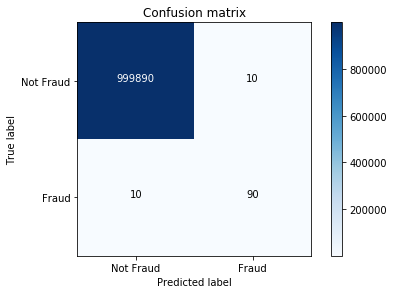

In [3]:
class_names = ['Not Fraud','Fraud']
plt.figure()
# the confusion matrix will be a 2 by 2 numpy array
cnf_matrix = np.array([[999890,10],[10,90]])
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

model2 predicted 2000 observations as fraud and 998000 as non-fraud. Among the 2000, 90 of them are truly frauds.

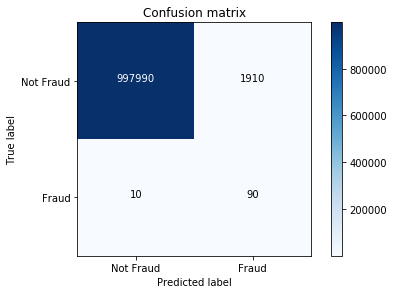

In [4]:
class_names = ['Not Fraud','Fraud']
plt.figure()
# the confusion matrix will be a 2 by 2 numpy array
cnf_matrix = np.array([[997990,1910],[10,90]])
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [5]:
TP = 90
TN = 997990
FP = 10
FN = 10
recall1 = TP / (TP + FN)
precision1 = TP / (TP + FP)
tpr1 = TP / (TP + FN)
fpr1 = FP / (TN + FP)
print("model 1\n")
print("Recall", recall1)
print("Precision", precision1)
print("True Positive Rate",tpr1 )
print("False Positive Rate: {:.5f}".format(fpr1))

TP = 90
TN = 997990
FP = 1910
FN = 10
recall2 = TP / (TP + FN)
precision2 = TP / (TP + FP)
tpr2 = TP / (TP + FN)
fpr2 = FP / (TN + FP)
print("\nmodel 2\n")
print("Recall", recall2)
print("Precision", precision2)
print("True Positive Rate", tpr2 )
print("False Positive Rate: {:.5f}".format(fpr2))

print("\nDifference between model 1 and 2\n")
print("TPR", tpr2 - tpr1)
print("FPR {:.5f}".format(fpr2 - fpr1))
print("Recall", recall2 - recall1)
print("Precision", precision1 - precision2)

model 1

Recall 0.9
Precision 0.9
True Positive Rate 0.9
False Positive Rate: 0.00001

model 2

Recall 0.9
Precision 0.045
True Positive Rate 0.9
False Positive Rate: 0.00191

Difference between model 1 and 2

TPR 0.0
FPR 0.00190
Recall 0.0
Precision 0.855


Obviously, those are just single points in ROC and PR space, but if these differences persist across various scoring thresholds, using ROC AUC, we'd see a very small difference between the two algorithms, whereas PR AUC would show quite a large difference.

False Positive Rate is affected by class imbalance. The first model has FP=10. Eventhough the second model has 2000 false positives, FP/FP + TN is affected by the size of TN which very high number. So the division will result in a small number and the difference between model 1 and model 2 is not well shown by the ROC AUC

See the difference in precision. PR is able to show which model is better regardless of the class imbalance. We only care about finding fraudlent transactions.


The Receiver operating characteristic (ROC) curve is the typical tool for assessing the performance of machine learning algorithms, but it actually does not measure well for imbalanced data. Consider an insurance company who needs to know a claim is fraudulent or not. The company needs to predict claims that may be fraudulent and take steps to prevent. Suppose 2% of 10,000 claims are fraudulent. If the data scientist predicts that ALL claims are not fraudulent, he gets 98% accuracy in the ROC curve. However, the data scientist totally missed the 2% true fraudulent claims.

In [6]:
# # understanding KFold

# from sklearn.model_selection import KFold
# X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
# y = np.array([1, 2, 3, 4])
# # n_splits = number of folds
# kf = KFold(n_splits=4)
# # the printed result is ararnged in this way ((array, array), ... ,(array, array))
# # it is tuple of tuples
# print(list(kf.split(X))) 
# print("shape: ", np.array(list(kf.split(X))).shape)
# for t, v in kf.split(X):
#     print(t, v)
#     X_train, X_test = X[t], X[v]
#     y_train, y_test = y[t], y[v]

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
https://medium.com/anomaly-detection-with-python-and-r/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8

In [7]:
credit = pd.read_csv("../../../Data & Script/creditcard.csv")

credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data Preprocessing

In [8]:
# X and Y
X = credit.iloc[:,:-1]
y = credit['Class']
print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


In [9]:
# split data into train, test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, shuffle=True)
print(X_train.shape)
print(X_test.shape)

(199364, 30)
(85443, 30)


In [10]:
# rescale Amount 
from sklearn.preprocessing import StandardScaler
# normalize seprately in train and test le
X_train['normAmount'] = StandardScaler().fit_transform(np.array(X_train['Amount']).reshape(-1,1))
X_train = X_train.drop(['Time','Amount'],axis=1)
X_test['normAmount'] = StandardScaler().fit_transform(np.array(X_test['Amount']).reshape(-1,1))
X_test = X_test.drop(['Time','Amount'],axis=1)

C:\Users\Tinsae\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Tinsae\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Undersampling

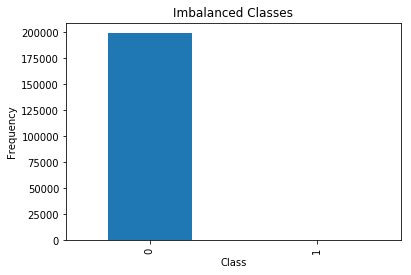

0    199008
1       356
Name: Class, dtype: int64


In [11]:
# see class imbalance probelm
count_classes = pd.value_counts(y_train, sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Imbalanced Classes")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
print(count_classes)

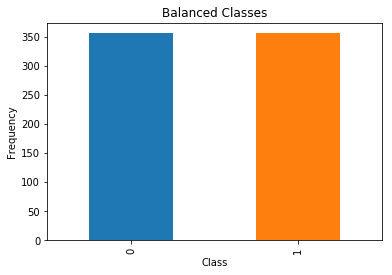

0    356
1    356
dtype: int64


In [12]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_sample(X_train, y_train)
X_test_resampled, y_test_resampled = rus.fit_sample(X_test, y_test)

count_classes = pd.value_counts(y_train_resampled, sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Balanced Classes")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
print(count_classes)

In [13]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1, penalty='l2', random_state=20, solver="liblinear")
clf.fit(X_train_resampled, y_train_resampled)
yhat = clf.predict(X_train_resampled)
print(clf.score(X_train_resampled, y_train_resampled))
print(pd.crosstab(y_train_resampled, yhat, rownames=['True'], colnames=['Predicted']))

0.9452247191011236
Predicted    0    1
True               
0          347    9
1           30  326


In [15]:
yhat = clf.predict(X_test_resampled)
print(clf.score(X_test_resampled, y_test_resampled))
print(pd.crosstab(y_test_resampled, yhat, rownames=['True'], colnames=['Predicted']))

0.9338235294117647
Predicted    0    1
True               
0          130    6
1           12  124
